In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import pymc3 as pm

%matplotlib inline

In [3]:
# skipping description and all entries before 2000
raw_weather = pd.read_csv('data/etmgeg_240.txt', skiprows=17945)

In [4]:
desc = ''
with open('data/etmgeg_240.txt', 'r') as f:
    for i in range(48):
        if i < 47:
            desc += f.readline()
        else:
            header = f.readline()[1:-2]
            header = header.replace(' ', '')
            columns = header.split(',')

In [5]:
print(desc)

BRON: KONINKLIJK NEDERLANDS METEOROLOGISCH INSTITUUT (KNMI)
Opmerking: door stationsverplaatsingen en veranderingen in waarneemmethodieken zijn deze tijdreeksen van dagwaarden mogelijk inhomogeen! Dat betekent dat deze reeks van gemeten waarden niet geschikt is voor trendanalyse. Voor studies naar klimaatverandering verwijzen we naar de gehomogeniseerde reeks maandtemperaturen van De Bilt <http://www.knmi.nl/kennis-en-datacentrum/achtergrond/gehomogeniseerde-reeks-maandtemperaturen-de-bilt> of de Centraal Nederland Temperatuur <http://www.knmi.nl/kennis-en-datacentrum/achtergrond/centraal-nederland-temperatuur-cnt>.

SOURCE: ROYAL NETHERLANDS METEOROLOGICAL INSTITUTE (KNMI)
Comment: These time series are inhomogeneous because of station relocations and changes in observation techniques. As a result, these series are not suitable for trend analysis. For climate change studies we refer to the homogenized series of monthly temperatures of De Bilt <http://www.knmi.nl/kennis-en-datacentrum/

In [6]:
raw_weather.columns = columns

In [7]:
raw_weather.head()

,STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV2
0,240,20000101,239,26,35,50,6,20,14,70,...,22,62,14,7,96,98,8,89,15,2
1,240,20000102,209,46,49,60,7,30,1,90,...,1,56,18,8,97,99,2,94,22,1
2,240,20000103,217,75,82,100,13,40,24,150,...,16,65,11,8,93,96,6,86,12,0
3,240,20000104,240,35,50,110,20,10,2,180,...,11,75,21,6,92,97,7,78,23,1
4,240,20000105,192,49,55,70,13,30,6,110,...,21,75,1,3,89,94,8,81,1,4


# Data cleaning

In [8]:
# there are only two rows with missing values for the variables below. Index 2060 lacks
# the rain duration value, whereas 5273 lacks the cloud cover value. I substituted the
# missing values by the most common value in the series: 0 rain, 7 cloud cover

weather = pd.DataFrame({'date': pd.to_datetime(raw_weather['YYYYMMDD'], format='%Y%m%d')})
weather['mean_temp'] = raw_weather['TG']/10
weather['max_temp'] = raw_weather['TX']/10
weather['min_temp'] = raw_weather['TN']/10
weather['sunshine_duration'] = raw_weather['SQ']
weather['rain_duration'] = pd.to_numeric(raw_weather['DR'].str.strip()).fillna(0).astype(int)
weather['rain_amount'] = raw_weather['RH']
weather['mean_pressure'] = raw_weather['PG']
weather['max_pressure'] = raw_weather['PX']
weather['min_pressure'] = raw_weather['PN']
weather['cloud_cover'] = pd.to_numeric(raw_weather['NG'].str.strip()).fillna(7).astype(int)
weather['mean_humidity'] = raw_weather['UG']
weather['max_humidity'] = raw_weather['UX']
weather['min_humidity'] = raw_weather['UN']
weather['global_radiation'] = raw_weather['Q']

In [9]:
weather.dtypes

date                 datetime64[ns]
mean_temp                   float64
max_temp                    float64
min_temp                    float64
sunshine_duration             int64
rain_duration                 int64
rain_amount                   int64
mean_pressure                 int64
max_pressure                  int64
min_pressure                  int64
cloud_cover                   int64
mean_humidity                 int64
max_humidity                  int64
min_humidity                  int64
global_radiation              int64
dtype: object

# TODO
Predict temperature
* Indentify seasonality on week and day. Suppose that that is the 'Normal' condition
* Identify outliers
* Use more variables to predict temperature
* Predict 1, 2, 10 days ahead. Identify deviations from seasonality, and the associated variables

In [10]:
weather.index = weather.date
# removing 2017 data to use as prediction test
weather_2017 = weather[weather.index >= pd.datetime(2016, 12, 28)]
weather = weather[weather.index < pd.datetime(2017, 1, 1)]

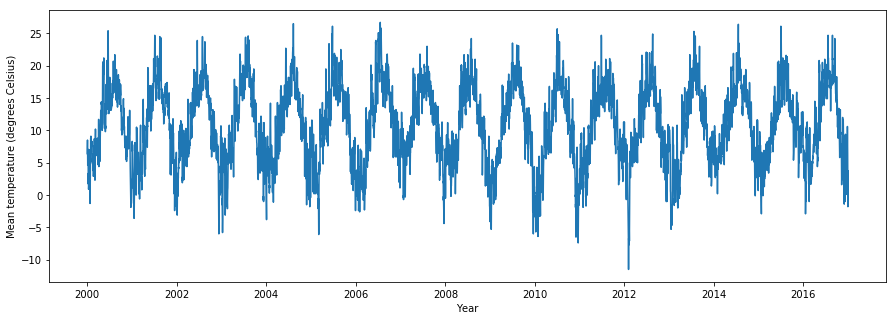

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(weather.index, weather.mean_temp)
ax.set_ylabel('Mean temperature (degrees Celsius)')
ax.set_xlabel('Year');

# Weekly seasonality

In [12]:
weather['weekofyear'] = weather.index.weekofyear

In [13]:
# Creating radial basis functions for week of the year
f_rbf = lambda x, alpha, mu: np.exp((-1/(2*alpha)) * (x - mu)**2)  # radial basis function
f_rbf_vec = lambda x: np.array([f(x) for f in [eval('lambda x: f_rbf(x, 1, {0})'.format(i))
                                      for i in np.arange(53)]])
weights_guess = np.ones(53)
woy = weather.weekofyear
y = weather.mean_temp

In [14]:
f_week_rbf = lambda weights, woy: np.dot(f_rbf_vec(woy).T, weights)

In [15]:
# Error function for least squares
def error(weights, woy):
    return f_week_rbf(weights, woy) - y

In [16]:
week_sol = optimize.least_squares(error, weights_guess, args=(woy,))

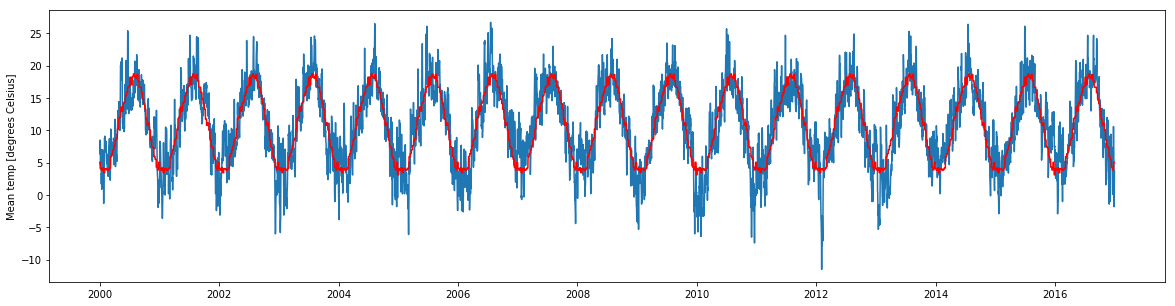

In [17]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(weather.index, weather.mean_temp);
ax.set_ylabel('Mean temp [degrees Celsius]')
ax.plot(weather.index, f_week_rbf(week_sol.x, woy), 'r');

# Factoring week seasonality out

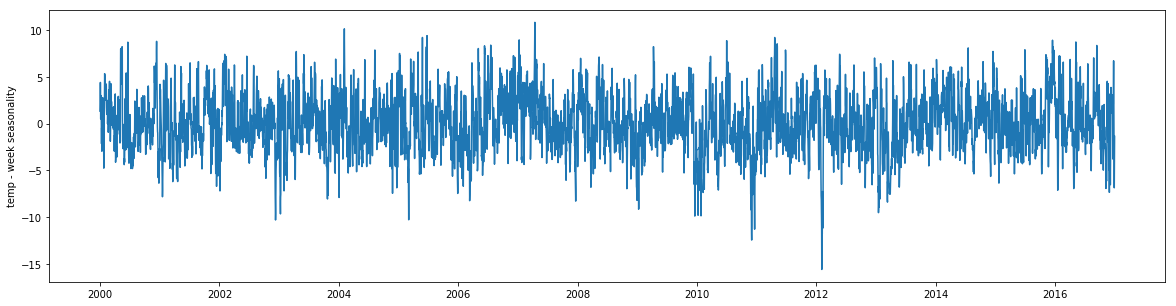

In [18]:
weather['no_week_season'] = weather['mean_temp'] - f_week_rbf(week_sol.x, woy)
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(weather.index, weather.no_week_season)
ax.set_ylabel('temp - week seasonality');

# Using other measurements to predict temperature

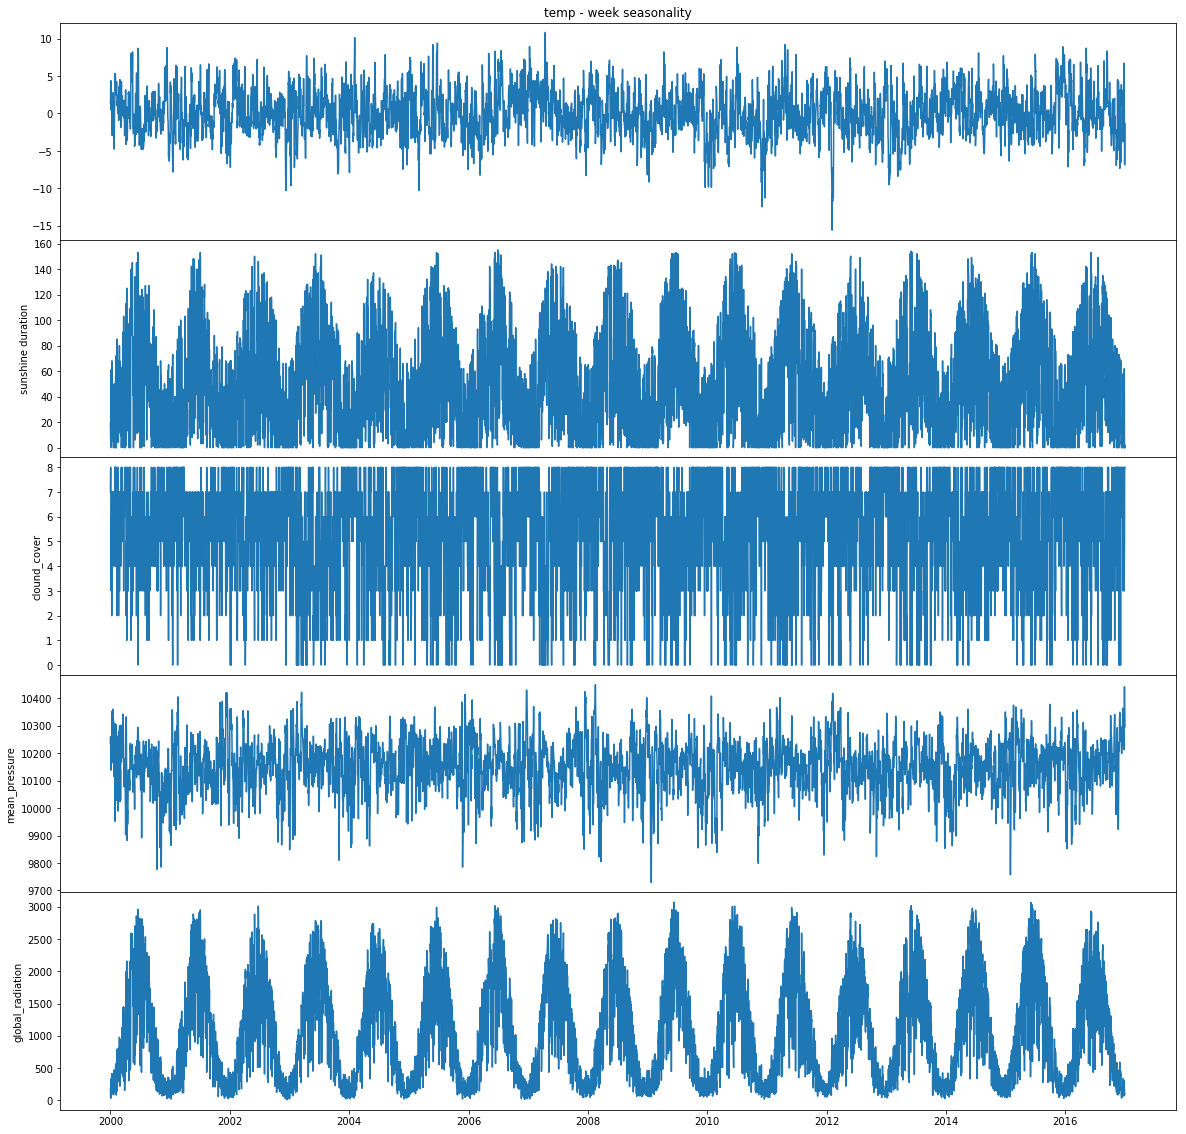

In [19]:
fig, ax = plt.subplots(nrows=5, figsize=(20, 20), sharex=True)
ax[0].plot(weather.index, weather.no_week_season)
ax[0].set_title('temp - week seasonality');
ax[1].plot(weather.index, weather.sunshine_duration)
ax[1].set_ylabel('sunshine duration')
ax[2].plot(weather.index, weather.cloud_cover)
ax[2].set_ylabel('clound_cover')
ax[3].plot(weather.index, weather.mean_pressure)
ax[3].set_ylabel('mean_pressure')
ax[4].plot(weather.index, weather.global_radiation)
ax[4].set_ylabel('global_radiation')
fig.subplots_adjust(hspace=0);

In [20]:
import statsmodels.formula.api as sm
from sklearn import preprocessing

X = preprocessing.scale(
    weather[['sunshine_duration', 'cloud_cover', 'mean_pressure']].values.astype(float))
y = weather.no_week_season.values.astype(float)
lr = sm.OLS(y, X,).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     39.38
Date:                Wed, 20 Dec 2017   Prob (F-statistic):           3.34e-25
Time:                        23:59:08   Log-Likelihood:                -15682.
No. Observations:                6210   AIC:                         3.137e+04
Df Residuals:                    6207   BIC:                         3.139e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4933      0.069      7.133      0.0

# Autoregression

In [21]:
minus_1 = weather.no_week_season.shift(1)[6:].values
minus_2 = weather.no_week_season.shift(2)[6:].values
minus_3 = weather.no_week_season.shift(3)[6:].values
minus_4 = weather.no_week_season.shift(4)[6:].values
minus_5 = weather.no_week_season.shift(5)[6:].values
minus_6 = weather.no_week_season.shift(6)[6:].values
observed = weather.no_week_season.values[6:]

In [22]:
model = pm.Model()
with model:
    one = pm.Normal('one')
    two = pm.Normal('two')
    three = pm.Normal('three')
    four = pm.Normal('four')
    five = pm.Normal('five')
    six = pm.Normal('six')
    mu = one*minus_1 + two*minus_2 + three*minus_3 + four*minus_4 + five*minus_5 + six*minus_6
    obs = pm.Normal('obs', mu=mu, observed=observed)

In [23]:
with model:
    adv_trace = pm.sample(10000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
  2%|▏         | 207/10500 [00:08<06:56, 24.74it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '15122' (I am process '15123')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/sr/.theano/compiledir_Darwin-14.5.0-x86_64-i386-64bit-i386-3.6.3-64/lock_dir
100%|██████████| 10500/10500 [04:27<00:00, 39.20it/s]
/anaconda3/envs/acceleratorX/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.888501205924, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


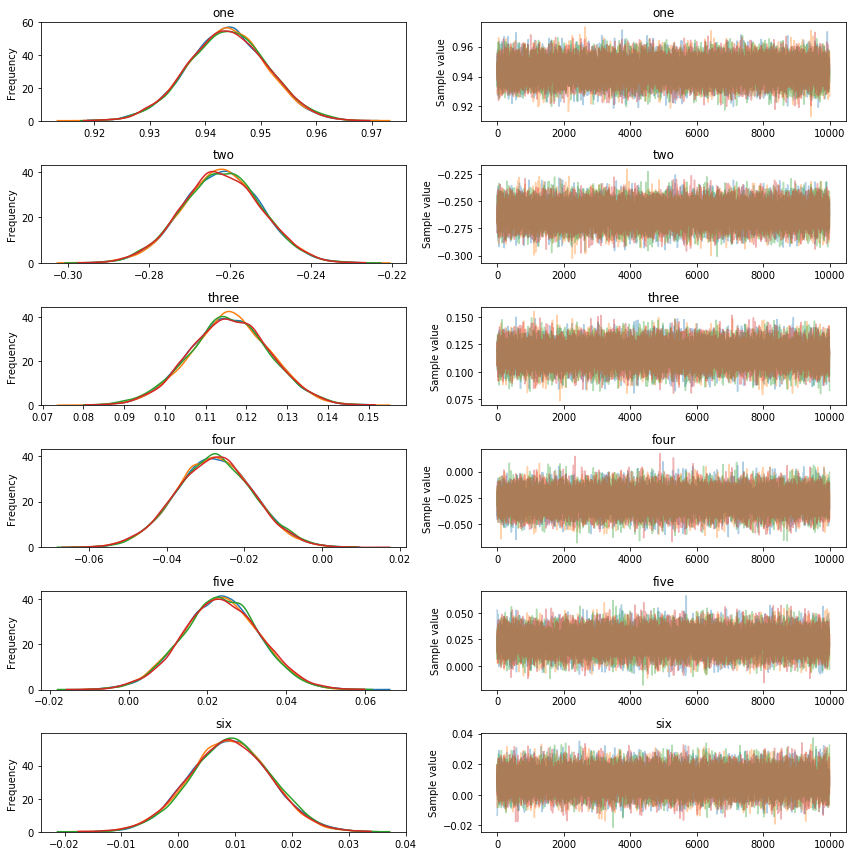

In [24]:
pm.traceplot(adv_trace);

In [25]:
# seems as only three days back are infromative of today
trace_df = pm.trace_to_dataframe(adv_trace)
trace_df.mean()
# The lines below take very long
#trace_df['loglik'] = [float(model.logp(adv_trace.point(i))) for i in range(len(adv_trace))]
#pd.plotting.scatter_matrix(trace_df, alpha=0.5, figsize=(6, 6), diagonal='kde');

one      0.944022
two     -0.262044
three    0.115829
four    -0.027805
five     0.023311
six      0.009063
dtype: float64

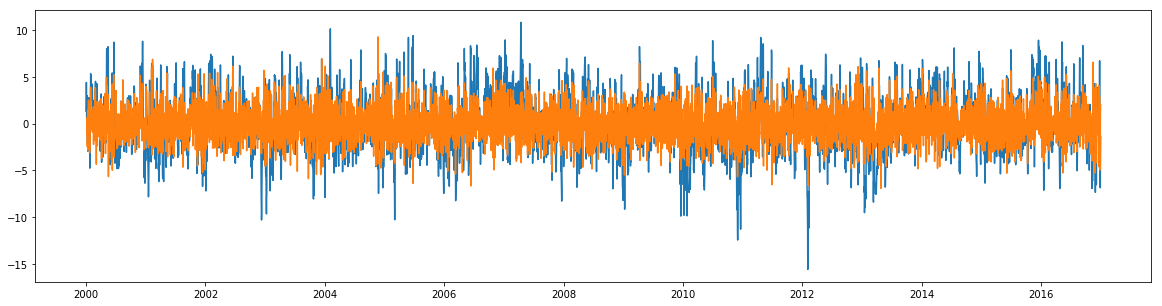

In [26]:
autocorr = (trace_df.mean()['one']*minus_1 + trace_df.mean()['two']*minus_2 + 
            trace_df.mean()['three']*minus_2)

no_auto = observed - autocorr
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(weather.index, weather.no_week_season)
ax.plot(weather.index[6:], no_auto);

# Composing prediction (fit)

In [27]:
this_year = pd.date_range(pd.datetime(2017, 1, 1), pd.datetime(2017, 12, 18))
df_2017 = pd.DataFrame({'wo_2017': this_year.weekofyear}, index=this_year)
df_2017['week_season'] = f_week_rbf(week_sol.x, df_2017['wo_2017'])

In [28]:
df_2017['autocorr'] = np.dot(np.array([
    weather_2017.shift(1)[3:]['mean_temp'].values,
    weather_2017.shift(2)[3:]['mean_temp'].values,
    weather_2017.shift(3)[3:]['mean_temp'].values
]).T - df_2017.week_season.values[:, np.newaxis], trace_df.mean()[:3].values)    
df_2017['prediction'] = df_2017['week_season'] + df_2017['autocorr']

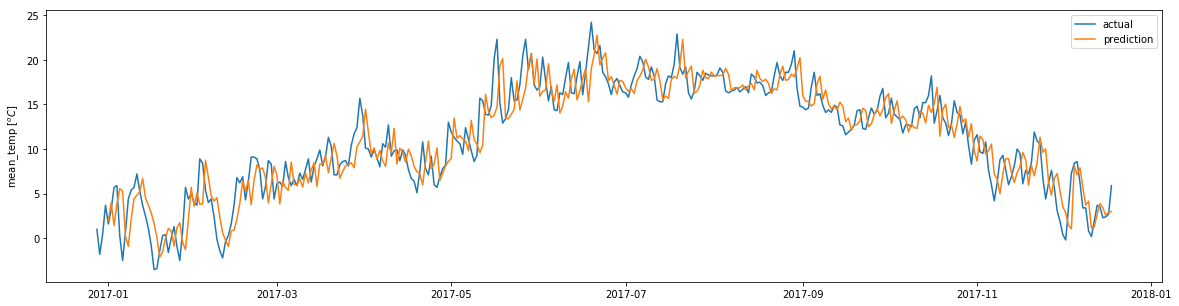

In [29]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(weather_2017.index, weather_2017['mean_temp'], label='actual')
ax.plot(df_2017.index, df_2017.prediction, label='prediction')
ax.set_ylabel('mean_temp [$^oC$]')
ax.legend();

In [32]:
df_2017['actual_mean_temp'] = weather_2017['mean_temp']

In [34]:
df_2017.to_pickle('pred_and_actual_2017_temp.pkl')